# Intro

In this notebook we will build a time series model that incorporates seasonalities, holidays, special events, and other features(regressors).

**Contents:**

* How to include seasonalities in time series prediction
* How to add standard holidays of a country
* How to add special events such as Super Bowl
* How to add additional predictors (regressors)
* Evaluate the impact of seasonalities, holidays, special events, and additional regressors on the prophet model.



# Step 1: Install and Import Libraries

In [ ]:
# Install libraries
!pip install yfinance prophet

In [2]:
# Get time series data
import yfinance as yf

# Prophet model for time series forecast
from prophet import Prophet

# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model performance evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Step 2: Pull Data

The second step pulls stock data from Yahoo Finance API. We will pull 2 years of daily data from the beginning of 2020 to the end of 2021.

* `start_date = '2021-01-01'`
* `end_date = '2023-06-01'` because `yfinance` excludes the end date, so we need to add one day to the last day of the data end date.
* `train_end_date = '2023-04-30'` We will use training data until April 30, 2023


In [3]:
# Data start date
start_date = '2021-01-01'

# Data end date. yfinance excludes the end date, so we need to add one day to the last day of data
end_date = '2023-06-01'

# Date for splitting training and testing dataset
train_end_date = '2023-04-30'

We will download the closing prices for two tickers, `GOOG` and `VTI`. `GOOG` is the ticker for Google, and `VTI` is the ticker for the Vanguard Total Stock Market Index Fund ETF.

The goal of the time series model is to predict the closing price of Google stock. The closing price of VTI will be used as an additional predictor.

In [4]:
# Pull close data from Yahoo Finance for the list of tickers
ticker_list = ['GOOG', 'VTI']
data = yf.download(ticker_list, start=start_date, end=end_date)[['Close']]

# Take a look at the data
data.head()

[*********************100%%**********************]  2 of 2 completed


Close            
                 GOOG         VTI
Date                             
2021-01-04  86.412003  191.869995
2021-01-05  87.045998  193.419998
2021-01-06  86.764503  195.160004
2021-01-07  89.362503  198.289993
2021-01-08  90.360497  199.250000

The downloaded dataset is in the pandas dataframe format. We can see that the output has two-level column names. Using `droplevel`, the first level column name `Close` is dropped.

In [5]:
# Drop one level of the column names
data.columns = data.columns.droplevel(0)

# Take a look at the data
data.head()

,GOOG,VTI
Date,,
2021-01-04,86.412003,191.869995
2021-01-05,87.045998,193.419998
2021-01-06,86.764503,195.160004
2021-01-07,89.362503,198.289993
2021-01-08,90.360497,199.250000


Using `.info`, we can see that the dataset has 505 records and there are no missing values.

In [6]:
# Information on the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 606 entries, 2021-01-04 to 2023-05-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOG    606 non-null    float64
 1   VTI     606 non-null    float64
dtypes: float64(2)
memory usage: 14.2 KB


Next, let's visualize the closing prices of the two tickers using `seaborn`, and add the legend to the plot using `matplotlib`. We can see that the price for Google increased starting in January 2021, and started dropping since January 2022.

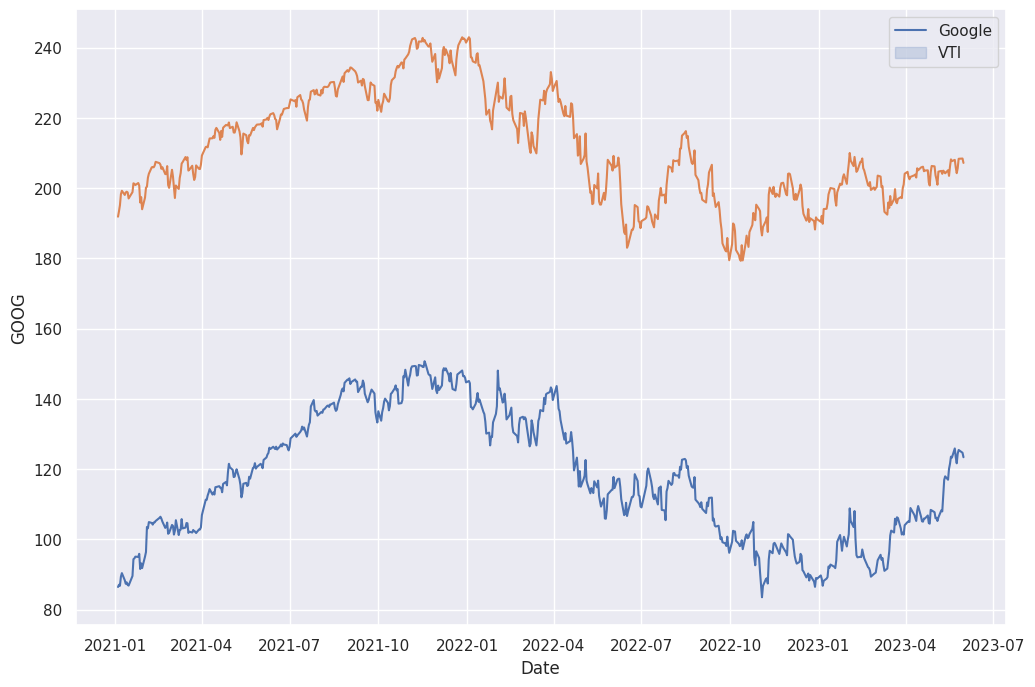

In [7]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data.index, y=data['GOOG'])
sns.lineplot(x=data.index, y=data['VTI'])
plt.legend(['Google', 'VTI'])

# Step 3: Data Processing

Prophet requires at least two columns as inputs: a `ds` column and a `y` column.
* The `ds` column has the time information. Currently we have the date as the index, so we reset the index and rename `date` to `ds`.
* The y column has the time series values. In this example, because we are predicting the Google closing price, the column name `GOOG` is changed to `y`.
* There is no pre-defined name for the additional predictor in prophet, so we can keep the name `VTI` as is.

In [8]:
# Change variable names
data = data.reset_index()
data.columns = ['ds', 'y', 'VTI']

# Take a look at the data
data.head()

,ds,y,VTI
0,2021-01-04,86.412003,191.869995
1,2021-01-05,87.045998,193.419998
2,2021-01-06,86.764503,195.160004
3,2021-01-07,89.362503,198.289993
4,2021-01-08,90.360497,199.250000


Next, let's check the correlation between the Google stock closing price and the VTI closing price.

In [9]:
# Check correlation
data.corrwith(data["y"])

<ipython-input-9-727934c321f9>:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corrwith(data["y"])


y      1.00000
VTI    0.90512
dtype: float64

The value of 0.9 is close to 1, indicating that there is a high correlation between the two closing prices. Therefore, VTI closing price is a potential good predictor for the Google closing price.

# Step 4: Train Test Split

For time series data, usually a threshold date is chosen, then we set the dates before the threshold to be the training dataset and the dates after the threshold to be the testing dataset.

Based on the threshold date (`train_end_date`) we set before, there are 584 data points in the training dataset and 22 data points in the testing dataset.

In [10]:
# Train test split
train = data[data['ds'] <= train_end_date]
test = data[data['ds'] > train_end_date]

# Check the shape of the dataset
print(train.shape)
print(test.shape)

(584, 3)
(22, 3)


# Step 5: Baseline Model

In step 5, we will build a univariate baseline model using the default prophet hyperparameters, and fit the model using the training dataset.

## Step 5.1: Build Baseline Model

In [11]:
# Use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()

# Fit the model on the training dataset
model_baseline.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpersq85wk/v4_ac3c2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpersq85wk/42pf32kx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56590', 'data', 'file=/tmp/tmpersq85wk/v4_ac3c2.json', 'init=/tmp/tmpersq85wk/42pf32kx.json', 'output', 'file=/tmp/tmpersq85wk/prophet_modeln5knloj1/prophet_model-20231030031755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:17:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:17:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet automatically fits daily, weekly, and yearly seasonalities if the time series is more than two cycles long.

The model information shows that the yearly seasonality and the daily seasonality are disabled.
* The daily seasonality is disabled because we do not have sub-daily time series.
* The yearly seasonality is disabled although we have two years of data because there are no stock price data on holidays and weekends, so we have less than 365 data points for each year.

We will continue with the default values for the baseline model and force the yearly seasonality in the next model to see the impact of the yearly seasonality.

## Step 5.2: Baseline Model Forecast

To make a forecast, we first need to create a future dataframe. `periods=30` means that we would like to make predictions for the next 30 days.

If you remember that the testing dataset has 22 data points, you might wonder why we put 30 instead of 22 as the number of periods here. That is because there are weekends. We need to add those days back in order to get the predictions till June 30th of 2023.

After making the prediction on the future dataframe, we can plot the result using `.plot`.

* The black dots are the actual values.
* The blue line is the prediction.
* The blue shades are the uncertainty interval. The default value for the uncertainty interval is 80%, so we are using 80% here. The uncertainty interval is calculated based on the assumption that the average frequency and magnitude of trend changes in the future will be the same as the historical data. The historical data trend changes are projected forward to get the uncertainty intervals.

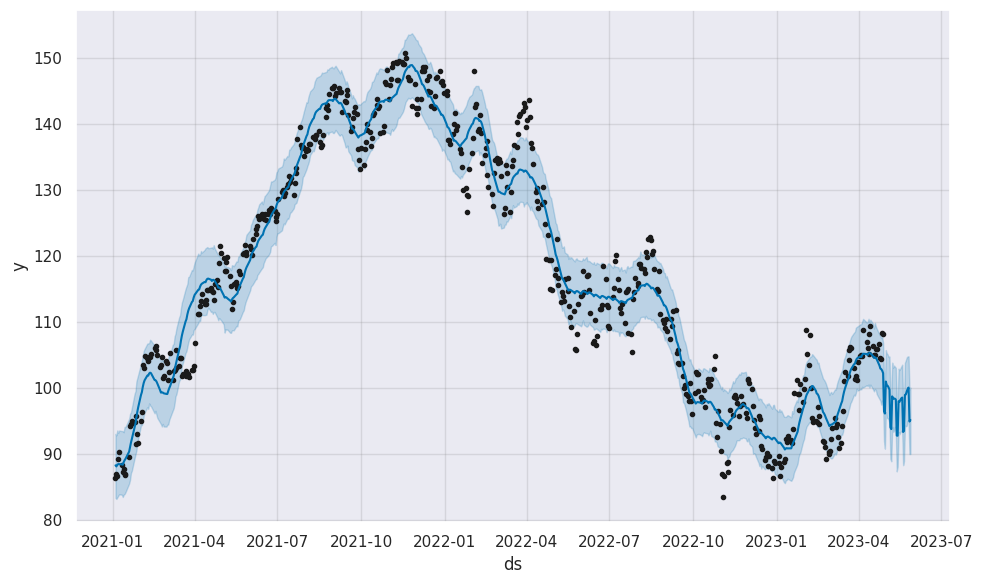

In [13]:
# Create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=30)

# Make prediction
forecast_baseline = model_baseline.predict(future_baseline)

# Visualize the forecast
model_baseline.plot(forecast_baseline); # Add semi-colon to remove the duplicated chart

In addition to the forecast plot, prophet also provides the components plot.

From the component plot chart, we can see that the Google stock closing price has an overall upward trend. The weekly seasonality shows that the price tends to be lower at the beginning of the week and higher at the end of the week.

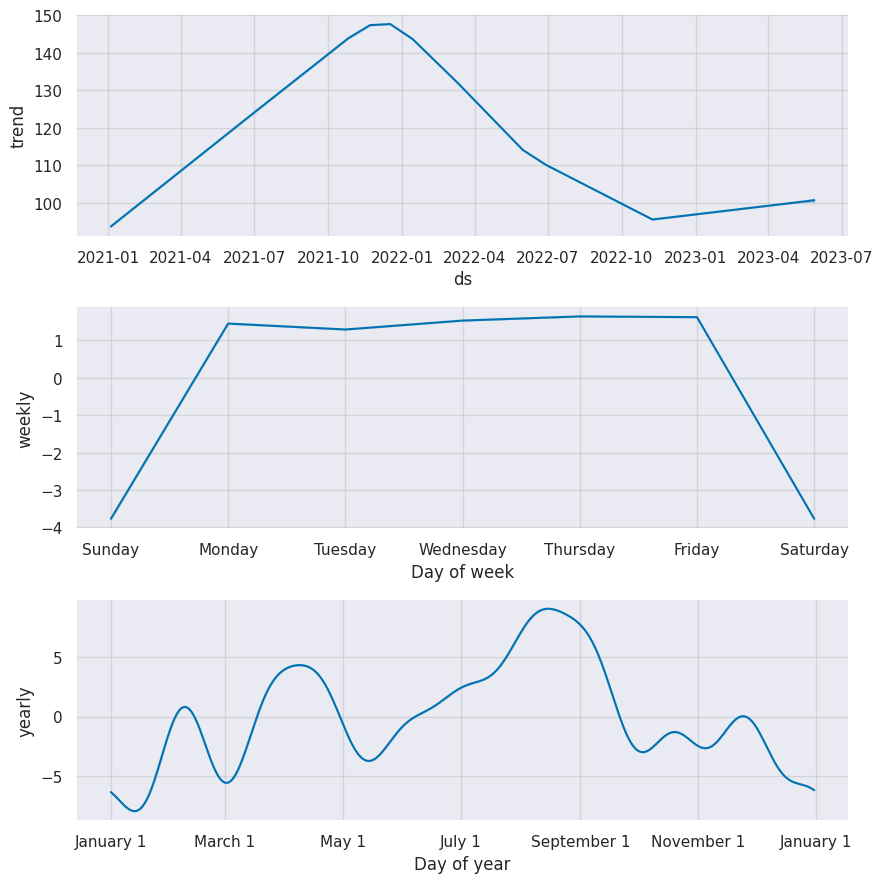

In [14]:
# Visualize the forecast components
model_baseline.plot_components(forecast_baseline);

## Step 5.3: Baseline Model Performance

Next, let's check the model performance.

The forecast dataframe does not include the actual values, so we need to merge the forecast dataframe with the test dataframe to compare the actual values with the predicted values.

The mean absolute error (MAE) for the baseline model is $16, meaning that on average, the forecast is off by \$16.85. Given the Google price of nearly \$250, the prediction is not bad.

The mean absolute percent error (MAPE) for the baseline model is 0.14%, meaning that on average, the forecast is off by 0.14% of the stock price.

In [16]:
# Merge actual and predicted values
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

# Check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')


The MAE for the baseline model is 16.859898217737378
The MAPE for the baseline model is 0.14147405831961013


# Step 6: Add Seasonality to Baseline Model

The baseline model already gives us good estimations. Can we tune the model to make the estimations better.

## Step 6.1 Build Model with Seasonality

When initiating the prophet model, the `yearly_seasonality` and `weekly_seasonality` are explicitly set to True, and then fit on the training data.

In [17]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Fit the model on the training dataset
model_season.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpersq85wk/1hqpkl2w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpersq85wk/qi_e7ulc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35953', 'data', 'file=/tmp/tmpersq85wk/1hqpkl2w.json', 'init=/tmp/tmpersq85wk/qi_e7ulc.json', 'output', 'file=/tmp/tmpersq85wk/prophet_modelhirbtb7l/prophet_model-20231030032343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:23:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:23:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Step 6.2: Seasonality Model Forecast

The forecast plot is much better than the baseline model. The predictions are more aligned with the actual values, and the uncertainty interval is much narrower.

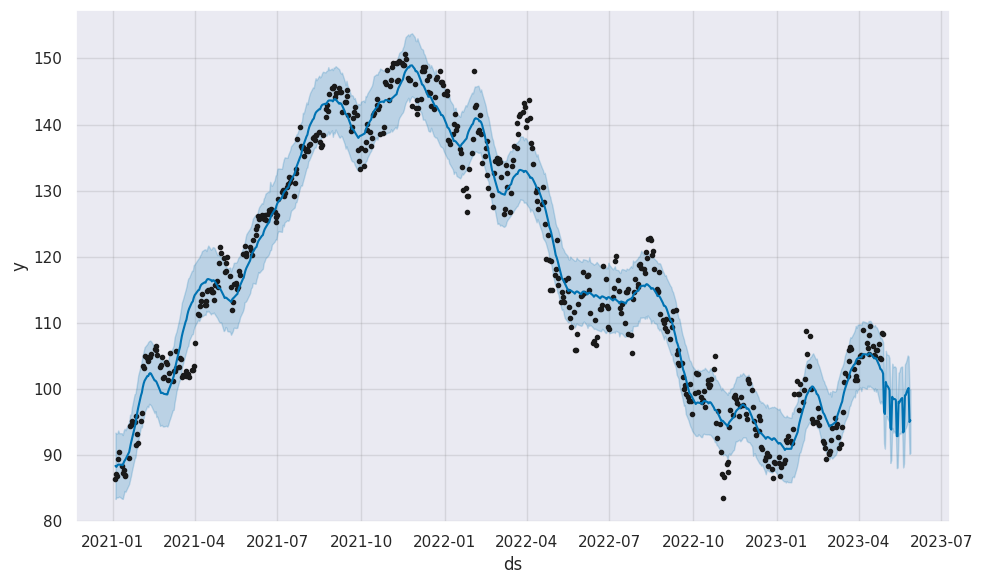

In [19]:
# Create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=30)

# Make prediction
forecast_season = model_season.predict(future_season)

# Visualize the forecast
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

For the components plot, besides trend and weekly seasonality, there is a yearly seasonality chart, showing the seasonality over the year.

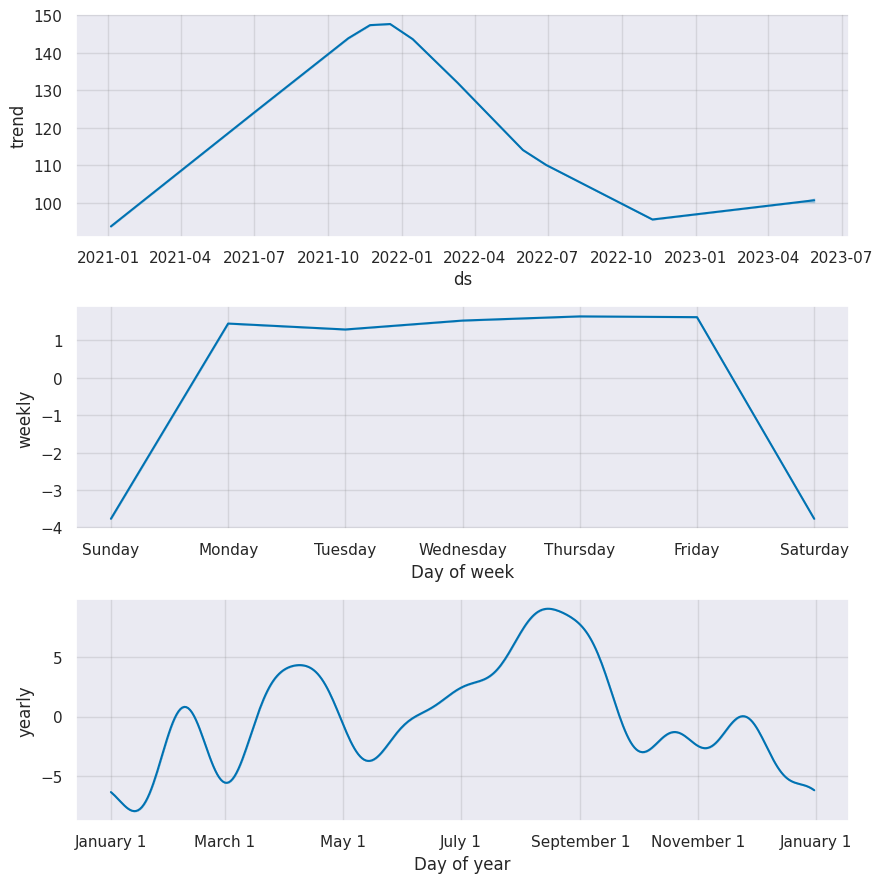

In [20]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

## Step 6.3: Seasonality Model Performance

In [21]:
# Merge actual and predicted values
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 23.693868742588513
The MAPE for the seasonality model is 0.19301540261208655


The model performance is better than the baseline model.
* MAE increased to \$23 from the baseline model's \$16.85. **It introduced noise to the model and decreased the model performance.**
* MAPE increased to 0.19% from the baseline model's 0.14%.

# Step 7: Multivariate Model

We will now add the VTI price as an additional regressor using the `add_regressor` function. `standardize=False` means the regressor will not be standardized.

VTI is chosen as a convenient example of illustrating the process of building a multivariate model. In practice, multiple features need to be created and evaluated as feature engineering and feature selection steps for the model.

## Step 7.1: Build the Multivariate Model

In [22]:
# Add seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('VTI', standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpersq85wk/1nof5z8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpersq85wk/b6shkvsp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92071', 'data', 'file=/tmp/tmpersq85wk/1nof5z8h.json', 'init=/tmp/tmpersq85wk/b6shkvsp.json', 'output', 'file=/tmp/tmpersq85wk/prophet_modelwq54a_l4/prophet_model-20231030032904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:29:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:29:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Step 7.2: Multivariate Model Forecast

When making forecasts for the multivariate model, we need to make sure that the regressors have values for the forecast periods, so we used left join and appended VTI data to the future dataframe.

In the case that the forecast is for the future without the regressor data, separate models need to be built for the regressors to get the predictions for the future dates.

If there are missing values, we can use `.fillna(method='ffill')` to fill the missing value with the previous day's data.

In [24]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=30)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, data[['ds', 'VTI']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,VTI
594,2023-05-15,205.089996
595,2023-05-16,203.500000
596,2023-05-17,206.139999
597,2023-05-18,208.190002
598,2023-05-19,207.690002
599,2023-05-22,208.050003
600,2023-05-23,205.850006
601,2023-05-24,204.259995
602,2023-05-25,205.649994
603,2023-05-26,208.360001


Compared with the model with no additional regressor, we can see that the model with a regressor has the predictions more aligned with the actual values.

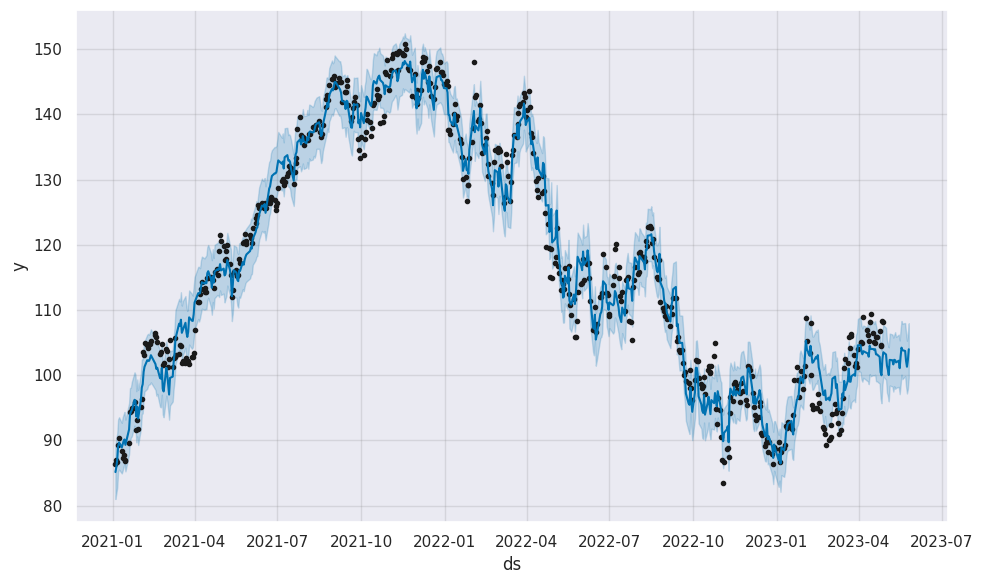

In [25]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

The components plot has one additional chart for the additional regressor.

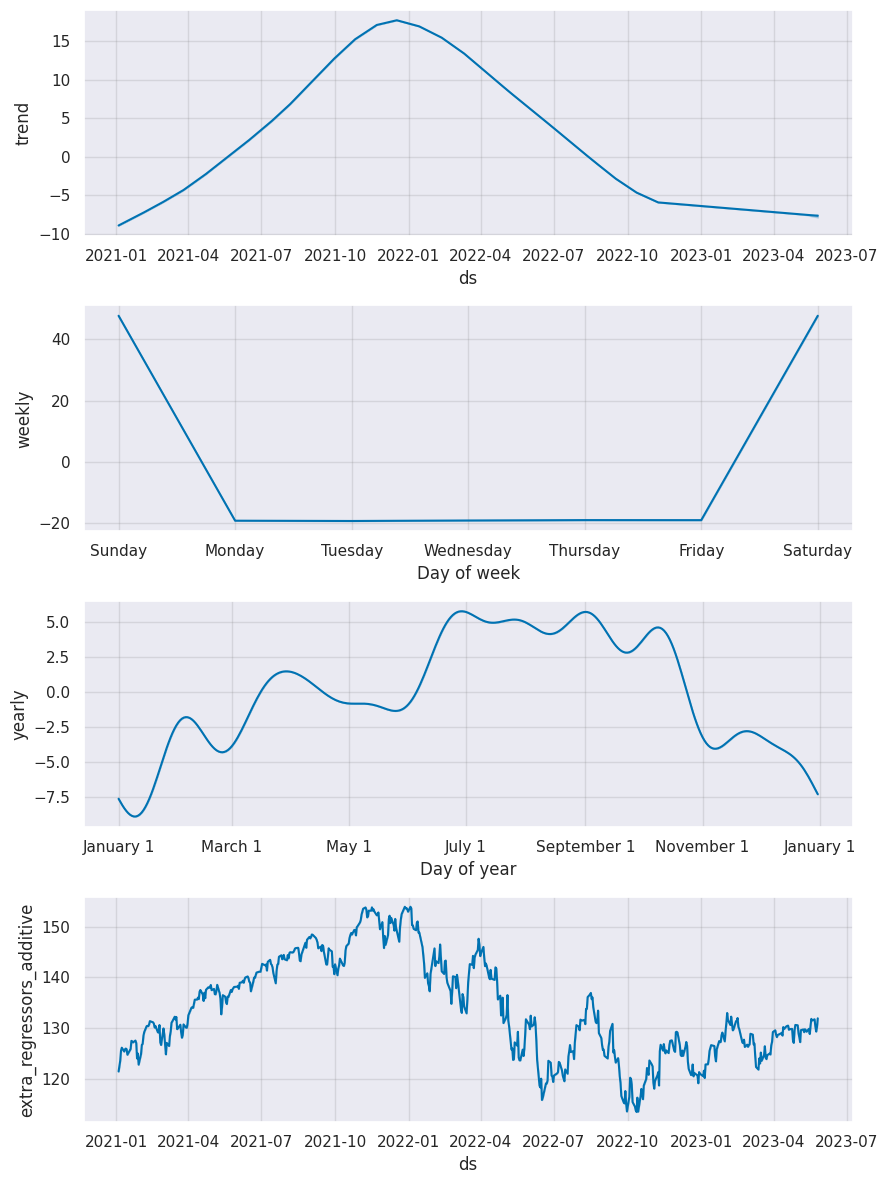

In [26]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

## Step 7.3: Multivariate Model Performance

In [27]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 13.705080955409702
The MAPE for the multivariate model is 0.11472318659940092


The multivariate model performance is much better than the univariate model.
* MAE decreased to \$13 from the univariate seasonality model's \$23.
* MAPE decreased to 0.11% from the univariate seasonality model's 0.14%.

# Step 8: Model with Holiday Effect and Event Effect

Besides seasonalities and additional predictors, we can also incorporate holidays and special events in a prophet time series model. We will now add special events and US holidays to the multivariate model and see how it impacts the model predictions.

## Step 8.1: Build Model with Holiday and Event Effect

Next, let's create two special events: COVID start and Super Bowl.

* For the COVID start event, we set the date to be January 04, 2021, (start of our data) then extend the event to 3 month after using `lower_window` and `upper_window` separately.

* For the Super Bowl event, we set the date in 2021 and 2022 separately, and extend the event to 7 days before and 1 day after.

Then the two events are concatenated together into one dataframe called `events`.

In [28]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2021-01-04']),
    'lower_window': 0,
    'upper_window': 90,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2021-02-07','2022-02-13']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

,holiday,ds,lower_window,upper_window
0,COVID,2021-01-04,0,90
0,superbowl,2021-02-07,-7,1
1,superbowl,2022-02-13,-7,1


When initiating the prophet model, the dataframe name `events` is passed to the hyperparameter `holidays`.

Prophet has built-in country-specific holidays. We add US holidays to the model using `add_country_holidays` and setting `country_name='US'`.

Using `.train_holiday_names`, we can see the list of holidays and events used for the modeling fitting.

In [29]:
# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')

# Add regressor
model_holiday.add_regressor('VTI', standardize=False)

# Fit the model on the training dataset
model_holiday.fit(train)

# All the holidays and events
model_holiday.train_holiday_names

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpersq85wk/5wh1b8sh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpersq85wk/pjxxpe_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98630', 'data', 'file=/tmp/tmpersq85wk/5wh1b8sh.json', 'init=/tmp/tmpersq85wk/pjxxpe_n.json', 'output', 'file=/tmp/tmpersq85wk/prophet_modelutv9wn2i/prophet_model-20231030033320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:33:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:33:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


0                                               COVID
1                                           superbowl
2                          Martin Luther King Jr. Day
3                               Washington's Birthday
4                                        Columbus Day
5                                      New Year's Day
6                           New Year's Day (Observed)
7                                        Memorial Day
8                Juneteenth National Independence Day
9     Juneteenth National Independence Day (Observed)
10                                   Independence Day
11                        Independence Day (Observed)
12                                          Labor Day
13                                       Veterans Day
14                                       Thanksgiving
15                                      Christmas Day
16                           Christmas Day (Observed)
17                            Veterans Day (Observed)
dtype: object

## Step 8.2: Holiday Model Forecast

When doing a forecast, the holiday and special events effects are included.

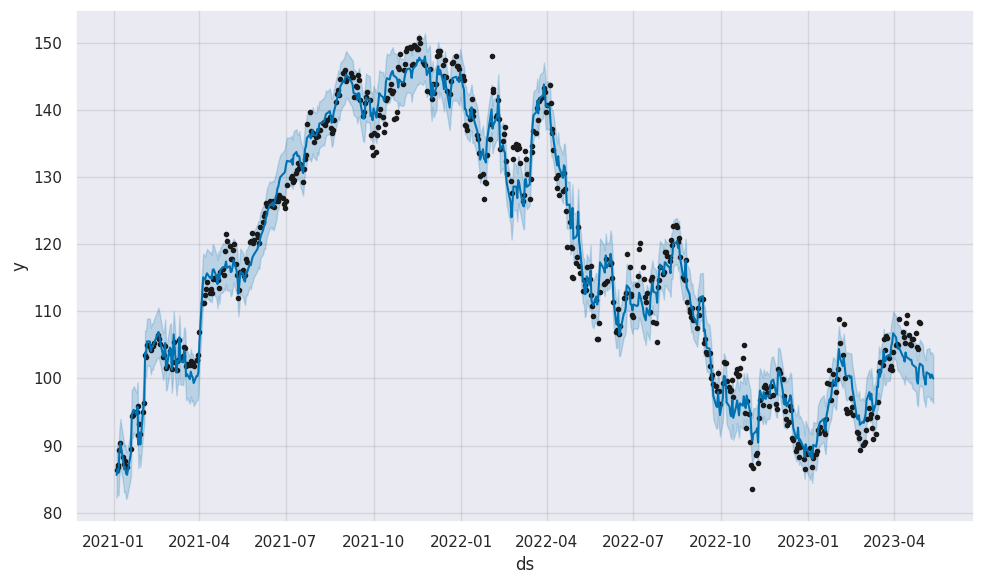

In [30]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=16)

# Append the regressor values
future_holiday = pd.merge(future_holiday, data[['ds', 'VTI']], on='ds', how='inner')

# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

The components plot has one additional plot for the holidays including special events.

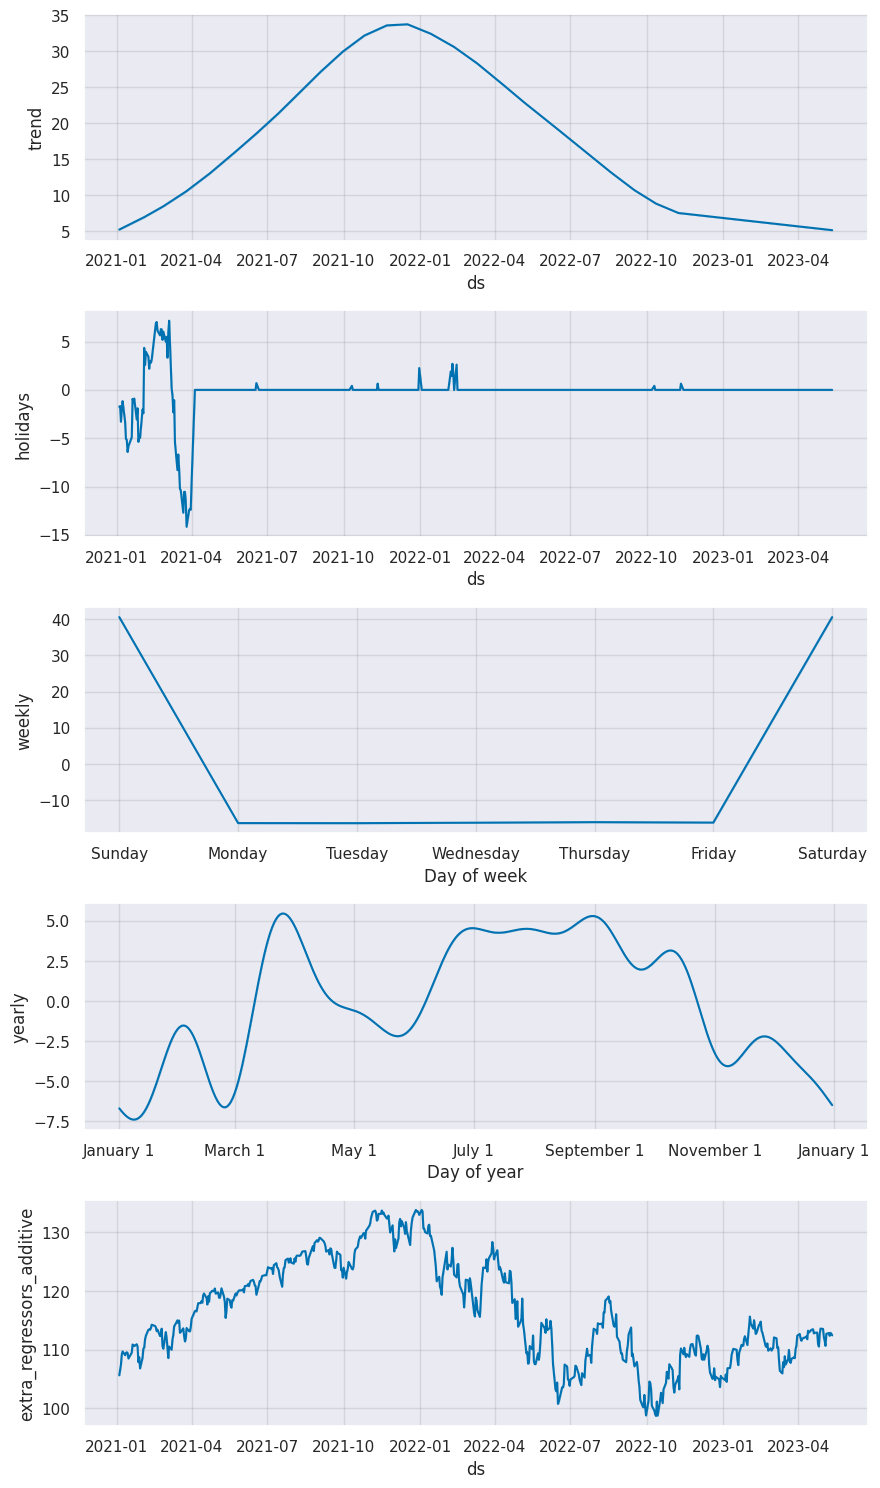

In [31]:
# Visualize the forecast components
model_holiday.plot_components(forecast_holiday);

## Step 8.3: Holiday Model Performance

In [32]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 9.073450686147702
The MAPE for the holiday/event model is 0.08148338150966145


The added holiday effects improved the performance of the multivariate model.

* MAE decreased to \$9 from the multivariate model's \$13.
* MAPE increased to 0.08% from the multivariate model's 0.11%.

This shows that the holidays and two special events added are good predictors for Google's stock price changes.

Holiday' and special events are always good predictors for retail sales predictions.